## Loading of Steinmetz data

includes some visualizations

In [ ]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['figure.facecolor'] = [1, 1, 1]
rcParams['font.size'] = 15
rcParams['legend.fontsize'] = 10
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [ ]:
import pickle

barea = {}
for i in range(39):
  barea[i] = alldat[i]['brain_area']

with open('barea', 'wb') as inf:
  pickle.dump(barea, inf)

array([0.65934965])

In [ ]:
import pickle as pk

behav_readout = {}
behav_readout['description']= "three keys: rt, go_cue, wheel_spd, feedback, resp_dir;\
            each contains a dict having session ids as its keys"
behav_readout = {'rt':{},
                 'gc':{},
                 'whl_spd':{},
                 'feedback':{},
                 'resp_dir':{}}
for i in range(39):
  behav_readout['rt'][i] = alldat[i]['response_time']
  behav_readout['gc'][i] = alldat[i]['gocue']
  feedback = alldat[i]['feedback_type']; behav_readout['feedback'][i] = feedback
  wheel_spd = alldat[i]['wheel']; behav_readout['whl_spd'][i] = wheel_spd
  behav_readout['resp_dir'][i] = alldat[i]['response']

with open('behav_readout_vals', 'wb') as outf:
  pk.dump(behav_readout, outf)

NameError: ignored

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [ ]:
# @title mouse names
names = {}
for i in range(39):
  dat = alldat[i]
  nm = dat['mouse_name']
  if nm not in names:
    names[nm] = 1
  else:
    names[nm] += 1

names

{'Cori': 3,
 'Forssmann': 4,
 'Hench': 4,
 'Lederberg': 7,
 'Moniz': 3,
 'Muller': 3,
 'Radnitz': 5,
 'Richards': 5,
 'Tatum': 4,
 'Theiler': 1}

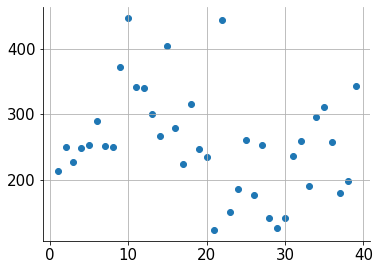

In [ ]:
# @title No of trials per session
Ntrials = []
for i in range(39):
  dat = alldat[i]
  Ntrials.append(dat['spks'].shape[1])

ax = plt.subplot(1,4,1)
plt.scatter(range(1, 40), Ntrials, label = "No of trials")
plt.grid(True)
plt.show()

# brief description of the dat['spks'] array
# (x, y, z)
# x -> number of brain areas covered
# y -> number of trials
# z -> time points recorded

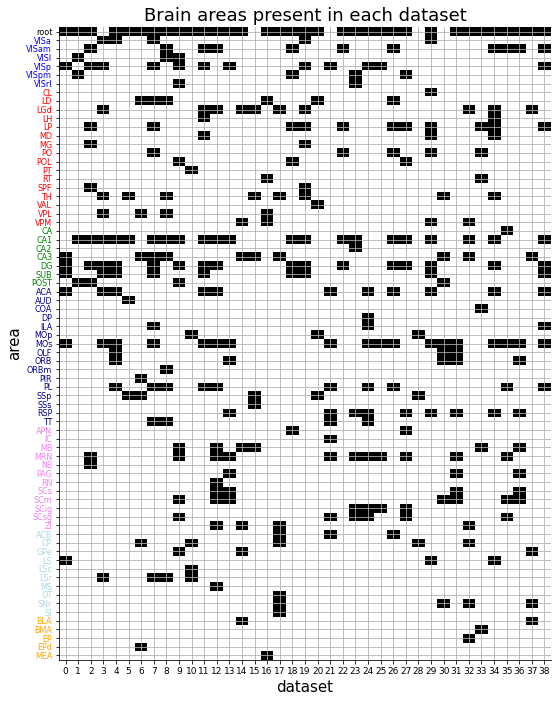

In [ ]:
#@title Session and region recorded
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

-0.024243599689681924 -0.011940298507462687 0.3325373134328358 0.3444776119402985


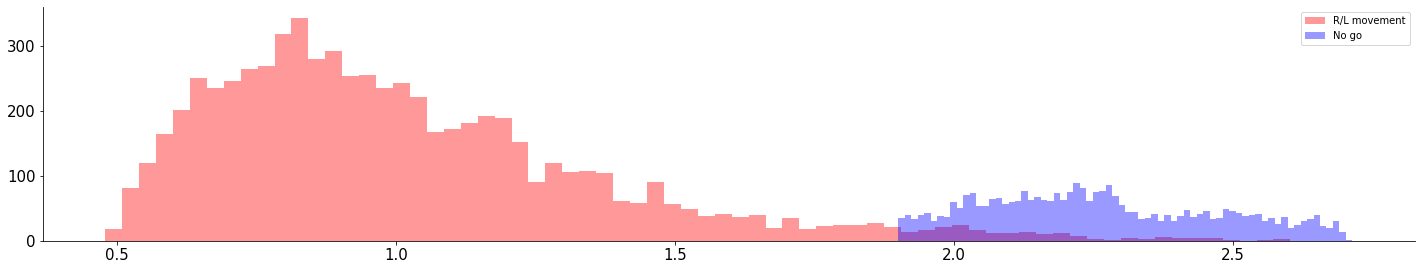

In [ ]:
# @title Response time distribution
reaction_time = np.array([]); response_time = np.array([])
resp_type = np.array([])
wheel_dir = np.array([])
right = np.array([]); left = np.array([])
for i in range(39):
  dat = alldat[i]
  reaction_time = np.hstack((reaction_time, dat['reaction_time'][:,0]))
  response_time = np.hstack((response_time, dat['response_time'].flatten()))
  right = np.hstack((right, dat['contrast_right']))
  left = np.hstack((left, dat['contrast_left']))
  resp_type = np.hstack((resp_type, dat['response']))

diff = right - left
print(diff[reaction_time==np.inf].mean(), diff.mean(), right.mean(), left.mean())

plt.hist(response_time[resp_type!=0], bins = 70, color = 'r', alpha = 0.4);
plt.hist(response_time[resp_type==0], bins = 70, color = 'b', alpha = 0.4);
plt.legend(["R/L movement", "No go"]);

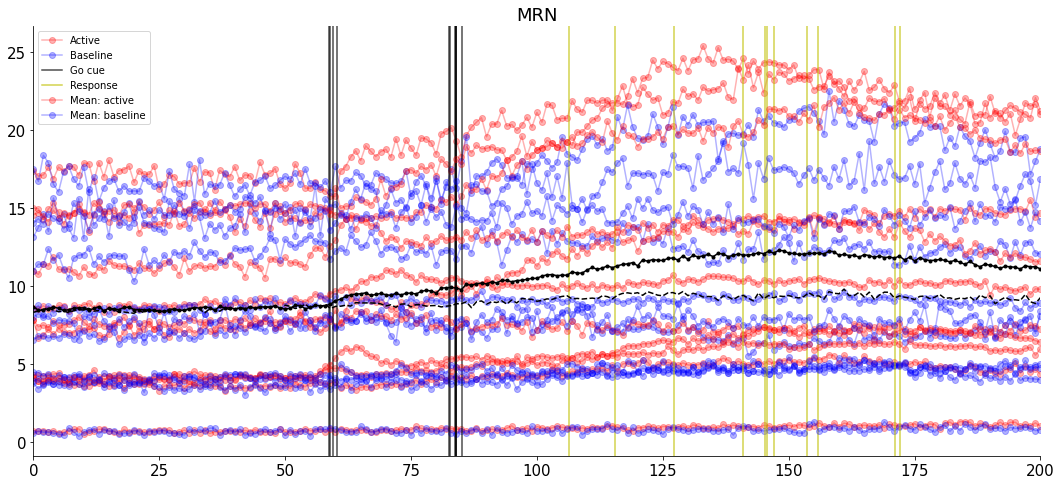

In [ ]:
# @markdown Plot aligned by stim onset
some_spike = np.zeros((250,))
base_spike = np.zeros((250,))
N = 0
region = "MRN"

ax = plt.subplot(1,1,1)

for i in range(39):
  dat = alldat[i]; dt = dat['bin_size']
  vis_right = dat['contrast_right']  # 0 - low - high
  vis_left = dat['contrast_left']  # 0 - low - high
  barea = dat['brain_area']
  if region in barea:
    N += 1
    spike_data = dat['spks'][barea == region, :, :]
    # some activity
    ax.plot(1/dt * spike_data[:,np.logical_or(vis_right > 0, vis_left > 0),:].mean(axis = (0,1)),
            'ro-', alpha = 0.3);
    some_spike += spike_data[:,np.logical_or(vis_right > 0, vis_left > 0),:].mean(axis = (0,1))
    # baseline activity
    ax.plot(1/dt * spike_data[:,np.logical_and(vis_right == 0, vis_left == 0),:].mean(axis = (0,1)),
            'bo-', alpha = 0.3);
    base_spike += spike_data[:,np.logical_and(vis_right == 0, vis_left == 0),:].mean(axis = (0,1))
    
    plt.axvline(1/dt * dat['gocue'].mean(), 0, 5.5, color = 'k', alpha = 0.7)
    plt.axvline(1/dt * dat['response_time'].mean(), 0, 5.5, color = 'y', alpha = 0.7)

#plt.plot(1/dt * spiking_rate, 'ro-', alpha = 0.7)
some_spike /= N; base_spike /= N
ax.plot(1/dt * some_spike, 'k.-')
ax.plot(1/dt * base_spike, 'k--')
plt.xlim(0, 200)
plt.legend(["Active", "Baseline", "Go cue", "Response", "Mean: active", "Mean: baseline"])
plt.title(region);

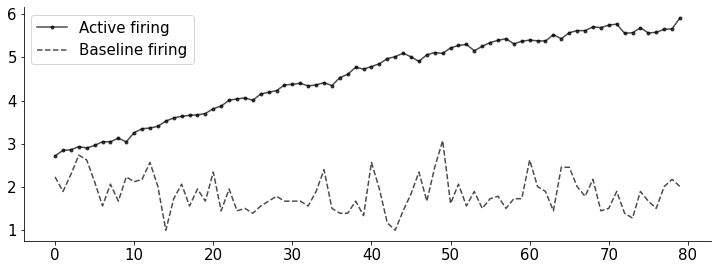

In [ ]:
#@markdown MOp firing for 11th trial (don't run this block)
ax = plt.subplot(1,2,1)
dt = alldat[10]['bin_size']
ax.plot(1/dt * dat[:,resp == 1,:].mean(axis = (0,1)), 'k.-', alpha = 0.7)
ax.plot(1/dt * dat[:,resp == 0,:].mean(
    axis = (0,1)), 'k--', alpha = 0.7)
ax.legend(["Active firing", "Baseline firing"])

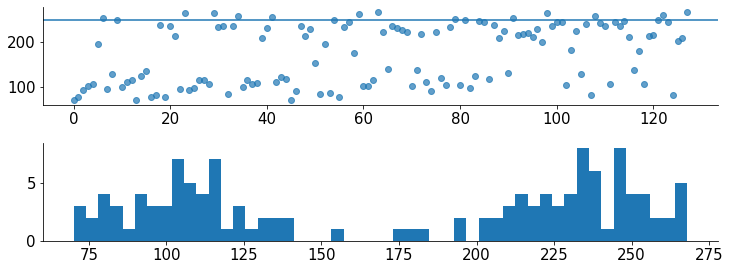

In [ ]:
#@markdown resp times for 11th trial (don't run this block)
# to illustrate that there are some RT vals > 2.5s
dat, resp = align_data_by_rt(28, 'MOp')

In [ ]:
# @title Align spike train based on the response time
# @markdown `align_data_by_rt(index, region_of_interest, l_pad=45, r_pad=20`<br>
# @markdown Returns firing rate matrix for a region, for `index`th session in the time window (resp-l_pad, resp+l_pad)
def align_data_by_rt(index, motor_region, l_pad = 45, r_pad = 20):
  dat = alldat[index]
  resp_time = dat['response_time']
  dt = dat['bin_size']
  
  barea = dat['brain_area']
  if motor_region not in barea:
    raise KeyError(motor_region + " not included")

  spike = dat['spks'][barea == motor_region,:,:]
  # N = no of trials, T = total time of recording
  N = spike.shape[1]; T = spike.shape[-1]
  # no of trials with RT <= 2.2s
  trial_less = []

  time_index = np.array([False]*(N*T)).reshape((N,T))
  aligned_dat = np.array([])
  for i in range(N):
    resp = int(1/dt * resp_time[i])
    if resp > 250-r_pad or resp < l_pad:
      trial_less.append(False)
      continue

    # resp - l_pad to resp + r_pad
    time_index[i,resp-l_pad:resp+r_pad] = True; 
    trial_less.append(True)
  

  aligned_dat = spike[:, time_index].reshape(
      spike.shape[0], -1, l_pad + r_pad)
  return aligned_dat, trial_less

dat, resp = align_data_by_rt(14, 'ZI')
print(dat.shape)

# (note) the time duration for recording is .5 + 2s
# RTs more than 2.5, how?

(55, 404, 65)


In [ ]:
# @title Align spike train based on go cue
# @markdown `align_data_by_gc(index, region_of_interest, l_pad=20, r_pad=70`<br>
# @markdown Returns firing rate matrix for a region, for `index`th session in the time window (gc-l_pad, gc+l_pad)
def align_data_by_rt(index, motor_region, l_pad = 20, r_pad = 70):
  dat = alldat[index]
  gocue = dat['gocue']
  dt = dat['bin_size']
  
  barea = dat['brain_area']
  if motor_region not in barea:
    raise KeyError(motor_region + " not included")

  spike = dat['spks'][barea == motor_region,:,:]
  # N = no of trials, T = total time of recording
  N = spike.shape[1]; T = spike.shape[-1]
  # no of trials with RT <= 2.2s
  trial_less = []

  time_index = np.array([False]*(N*T)).reshape((N,T))
  aligned_dat = np.array([])
  for i in range(N):
    gc = int(1/dt * gocue[i])
    if gc > 250-r_pad or gc < l_pad:
      trial_less.append(False)
      continue

    # gc - l_pad to gc + r_pad
    time_index[i,gc-l_pad:gc+r_pad] = True; 
    trial_less.append(True)
  

  aligned_dat = spike[:, time_index].reshape(
      spike.shape[0], -1, l_pad + r_pad)
  return aligned_dat, trial_less

dat, resp = align_data_by_rt(14, 'ZI')
print(dat.shape)
print(len(resp))

(55, 404, 90)
404


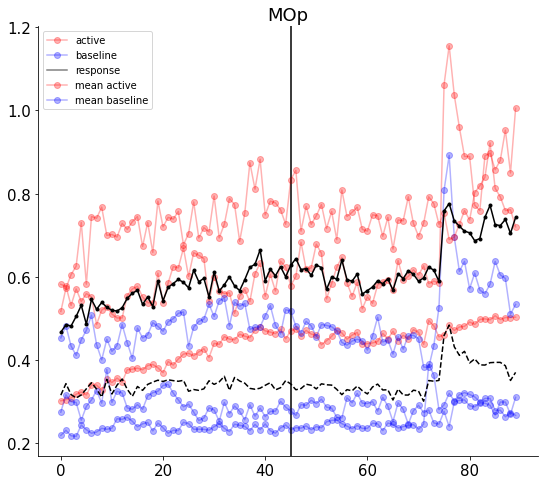

In [ ]:
# @markdown Plot of primary motor cortex (resp aligned, window -45, 20)
active = []; inactive = []
region = 'MOp'
n = 0
ax = plt.subplot(1,2,1)

for i in range(39):
  dt = 0.1
  resp_type = alldat[i]['response']
  try:
    aligned_dat, resp_slice = align_data_by_rt(i, region)
    resp_type = resp_type[resp_slice]
    n += 1

    dat_slice_a = aligned_dat[:, resp_type == 1, :].mean(
      axis = (0,1));
    ax.plot(1/dt * dat_slice_a, 'ro-', alpha = 0.3)
    active.append(dat_slice_a)

    # modification added: no slicing if there's no '0' in resp_type
    if 0 in resp_type:
      dat_slice_i = aligned_dat[:, resp_type == 0, :].mean(
          axis = (0,1));
      ax.plot(1/dt * dat_slice_i, 'bo-', alpha = 0.3)
      inactive.append(dat_slice_i)    

    ax.axvline(45, 0, 6.5, color = 'k', alpha = 0.5)
  except: 
    continue

active_mean = np.mean(np.array(active), axis = 0)
inactive_mean = np.mean(np.array(inactive), axis = 0)
ax.plot(1/dt * active_mean, 'k.-')
ax.plot(1/dt * inactive_mean, 'k--')
ax.legend(["active", "baseline", "response", "mean active", "mean baseline"])
ax.set_title(region);

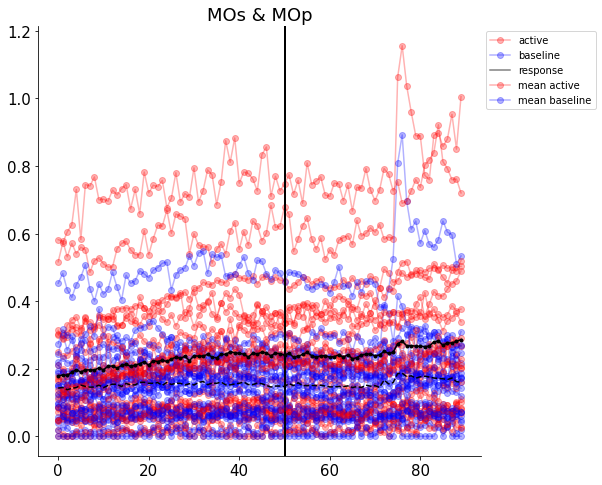

In [ ]:
# @markdown Plot of MOs, MOp (resp aligned, as before)

active = []; inactive = []
regions = ['MOs', 'MOp']
n = 0

ax = plt.subplot(1,2,1)

for i in range(39):
  dt = 0.1
  resp_type = alldat[i]['response']
  for region in regions:
    try:
      aligned_dat, resp_slice = align_data_by_rt(i, region)
      resp_type = resp_type[resp_slice]
      n += 1
      dat_slice_a = aligned_dat[:, resp_type == 1, :].mean(
        axis = (0,1));
      ax.plot(1/dt * dat_slice_a, 'ro-', alpha = 0.3)
      active.append(dat_slice_a)

      # modification added: no slicing if there's no '0' in resp_type
      if 0 in resp_type:
        dat_slice_i = aligned_dat[:, resp_type == 0, :].mean(
            axis = (0,1));
        ax.plot(1/dt * dat_slice_i, 'bo-', alpha = 0.3)
        inactive.append(dat_slice_i)    

      ax.axvline(50, 0, 6.5, color = 'k', alpha = 0.5)
    except: 
      continue

active_mean = np.mean(np.array(active), axis = 0)
inactive_mean = np.mean(np.array(inactive), axis = 0)
ax.plot(1/dt * active_mean, 'k.-')
ax.plot(1/dt * inactive_mean, 'k--')
ax.legend(["active", "baseline", "response", "mean active", 
           "mean baseline"], bbox_to_anchor=(1.0, 1.0), loc='upper left');
ax.set_title(' & '.join(regions));

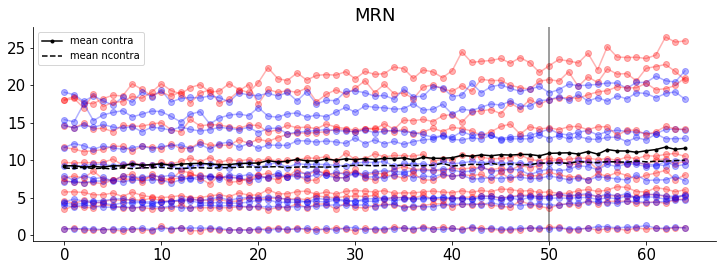

In [ ]:
#@markdown Plot firing rate of neurons with varying (contra - ipsi)contrast
ax = plt.subplot(1,2,1)

contra = []; not_contra = []
reg = 'MRN'; n = 0
for i in range(39):
  dt = alldat[i]['bin_size']
  rt, lf = alldat[i]['contrast_right'], alldat[i]['contrast_left']
  dif = rt - lf 
  try:
    aligned_dat, _slice = align_data_by_rt(i, reg)
    n += 1
    dif_sliced = dif[_slice]
    # right > left
    pos_dif = aligned_dat[:, dif_sliced > 0].mean(axis = (0,1))
    contra.append(pos_dif)
    ax.plot(1/dt * pos_dif, 'ro-', alpha = 0.3)
    # right <= left
    neg_dif = aligned_dat[:, dif_sliced <= 0].mean(axis = (0,1))
    not_contra.append(neg_dif)
    ax.plot(1/dt * neg_dif, 'bo-', alpha = 0.3)
  except:
    continue

contra_mean = np.mean(np.array(contra), axis = 0)
ncontra_mean = np.mean(np.array(not_contra), axis = 0)
ax.axvline(50, 0, 6.5, color = 'k', alpha = 0.5)
ax.plot(1/dt * contra_mean, 'k.-', label = "mean contra")
ax.plot(1/dt * ncontra_mean, 'k--', label = "mean ncontra")
ax.legend()
ax.set_title(reg);

In [ ]:
#@title Generate region specific firing details, RT aligned
#@markdown `generate_rtaln_dat_sesh(region_of_interest, l_pad=45, r_pad=20)` <br>
#@markdown Returns a dictionary with session index (0,..., 38) as keys and list as values, containing-<br>
#@markdown RT aligned spiking data [with dims: `(n_occurrence_reg, n-trials, window_len)`]<br>
#@markdown contrast_right, contrast_left [with dims: `(2, n_trials)`]<br>
#@markdown response [with dims: `(n_trials,)`]<br>
#@markdown slicing_index [list of len `n_trials`]<br>
#@markdown `dict['region']` should return the region name

def generate_rtaln_choice_dat(region_of_interest, l_pad=45, r_pad=20):
  sesh_dict = {}
  for i in range(39):
    contr_r, contr_l = alldat[i]['contrast_right'], alldat[i]['contrast_left']
    resp = alldat[i]['response']
    try:
      aligned_dat, slice_ind = align_data_by_rt(i, region_of_interest, l_pad, r_pad)
      contrast = np.vstack((contr_r[slice_ind], contr_l[slice_ind]))
      resp = resp[slice_ind]
      sesh_dict[i] = [aligned_dat, contrast, resp, slice_ind]
    except:
      continue

  sesh_dict['region'] = region_of_interest
  return sesh_dict


out = generate_rtaln_choice_dat('ZI')
print("Output type: ", type(out))
print("Length: ", len(out))
print("Sessions: ", [i for i in out.keys()])
print("Region: ", out['region'])
print("Items in dict[12]", [type(i) for i in out[12]])

Output type:  <class 'dict'>
Length:  5
Sessions:  [12, 14, 17, 32, 'region']
Region:  ZI
Items in dict[12] [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'list'>]


In [ ]:
import pickle as pk 
choice_areas = ['ZI', 'MRN', 'SCm', 'SNr', 'SSp', 'MOp', 'MOs']
choice_data = {}
for area in choice_areas:
  choice_data[area] = generate_rtaln_choice_dat(area)

with open('choice_signal_dat', 'wb') as outf: 
  pk.dump(choice_data, outf)

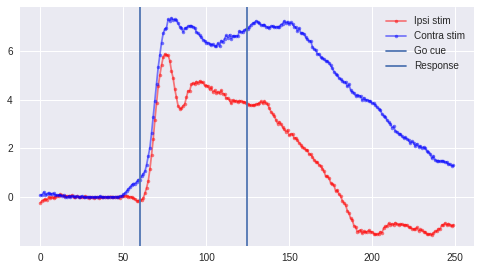

In [ ]:
#@markdown Clock- vs anticlockwise wheel speed<br>
#@markdown Why is contra response stronger? 
plt.subplot(1,3,1)
rt_stim, lf_stim = np.zeros((250,)), np.zeros((250,))
for i in range(39):
  dat = alldat[15]
  whl = dat['wheel']; resp = dat['response']
  rt, lf = dat['contrast_right'], dat['contrast_left']
  rt_stim += whl[0, resp < 0].mean(0); lf_stim += whl[0, resp > 0].mean(0)

plt.plot(lf_stim/39, 'r.-', alpha = 0.5);
plt.plot(np.abs(rt_stim)/39, 'b.-', alpha = 0.5);
plt.axvline((1/dat['bin_size'])*dat['gocue'].mean(), -5, 7)
plt.axvline((1/dat['bin_size'])*dat['response_time'].mean(), -5, 7)
plt.legend(["Ipsi stim", "Contra stim", "Go cue", "Response"])

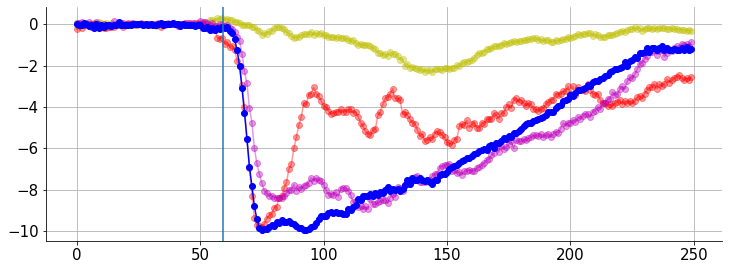

In [ ]:
#@markdown Wheel speed for different values of right_contrast-left_contrast
#@markdown for session index 16
def whl_turn_helper(whl_speed, contrast_dif, lbound, ubound):
  whl_slice = whl_speed[0, np.logical_and(lbound<=contrast_dif,
                                  contrast_dif<ubound)]
  return 1, whl_slice.mean(0)

plt.subplot(1,2,1)
dat = alldat[16]
whl = dat['wheel']
resp = dat['response']
rt, lf = dat['contrast_right'], dat['contrast_left']; dif = rt - lf
plt.plot(whl[0, np.logical_and(dif >= 0, dif < .25)].mean(0), 'yo-', alpha = 0.4)
plt.plot(whl[0, np.logical_and(dif >= .25, dif < .5)].mean(0), 'ro-', alpha = 0.4)
plt.plot(whl[0, np.logical_and(dif >= .5, dif < .75)].mean(0), 'mo-', alpha = 0.4)
plt.plot(whl[0, dif >= .75].mean(0), 'bo-')
plt.axvline(100*dat['gocue'].mean(), -10, 2)
ax.legend(["[0,.25)", "[.25,.5)", "[.5,.75)", ">.75", "Mean gocue"])
plt.grid(True)

32


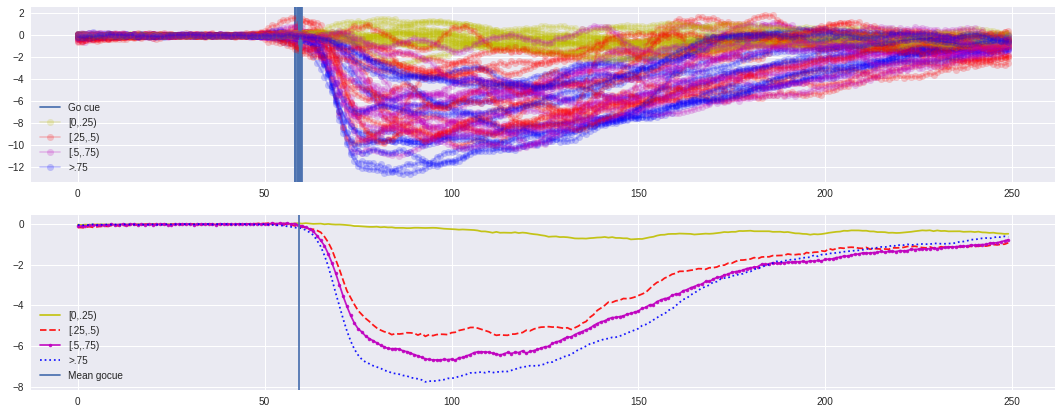

In [ ]:
#@markdown Same as before, just averaged over all sessions
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 6)
whl_speed = np.zeros((5, 250)); n, m = 0, 0
gocue = 0
ax = plt.subplot(2,1,1)
for i in range(39):
  dat = alldat[i]
  gc_val = 100*dat['gocue'].mean()
  if gc_val < 60:
    # plot gocue
    ax.axvline(gc_val, -10, 2)
    gocue += gc_val
    n += 1

    # wheel turn/ 10ms bin
    whl = dat['wheel']
    # right - left contrast, response time
    rt, lf = dat['contrast_right'], dat['contrast_left']; dif = rt - lf
    resp_time = dat['response_time']

    # 0 <= rt - lf <.25
    whl_temp = whl[0, np.logical_and(dif >= 0, dif < .25)].mean(0)
    ax.plot(whl_temp, 'yo-', alpha = 0.2); whl_speed[0,:] += whl_temp

    # .25 <= rt - lf <.5
    whl_temp = whl[0, np.logical_and(dif >= .25, dif < .5)].mean(0)
    ax.plot(whl_temp, 'ro-', alpha = 0.2); whl_speed[1,:] += whl_temp

    # .5 <= rt - lf <.75
    whl_temp = whl[0, np.logical_and(dif >= .5, dif < .75)].mean(0)
    ax.plot(whl_temp, 'mo-', alpha = 0.2); whl_speed[2,:] += whl_temp

    # .75 <= rt - lf
    whl_temp = whl[0, dif >= .75].mean(0)
    if np.all(whl_temp > -15) == False:
      m -= 1
      print(i)
      continue
    ax.plot(whl_temp, 'bo-', alpha = 0.2); whl_speed[3,:] += whl_temp


ax.legend(["Go cue", "[0,.25)", "[.25,.5)", "[.5,.75)", ">.75"])
plt.grid(True)

# mean plots
ax = plt.subplot(2,1,2)
ax.plot(whl_speed[0,:]/n, 'y-', alpha = 0.9)
ax.plot(whl_speed[1,:]/n, 'r--', alpha = 0.9)
ax.plot(whl_speed[2,:]/n, 'm.-', alpha = 0.9)
ax.plot(whl_speed[3,:]/(n+m), 'b:', alpha = 0.9)
ax.axvline(gocue/n, 2, -7); plt.grid(True)
ax.legend(["[0,.25)", "[.25,.5)", "[.5,.75)", ">.75", "Mean gocue"])

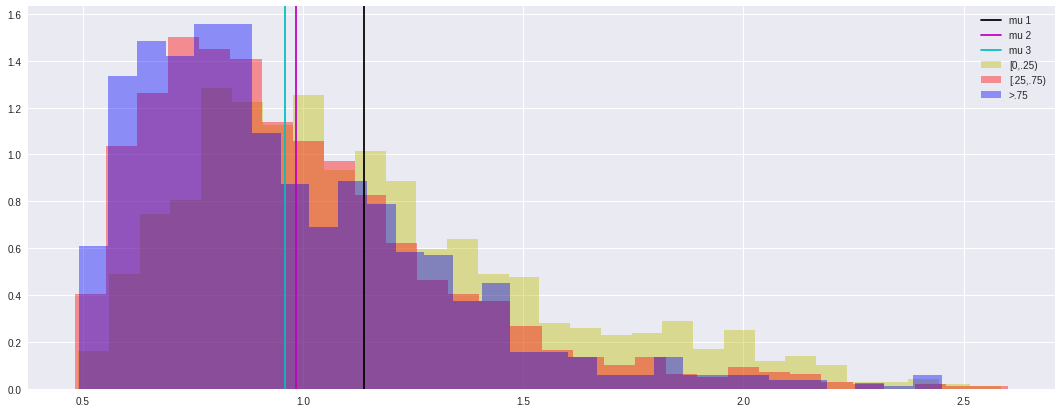

In [ ]:
#@markdown Dependence of RT on contrast diff
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 6)
rt_full = np.array([])
dif_full = np.array([])

for i in range(39):
  dat = alldat[i]
  rt = dat['response_time'].flatten()
  dif = dat['contrast_right'] - dat['contrast_left']
  resp_type = dat['response']
  rt = rt[resp_type!=0]; dif = dif[resp_type!=0]
  rt_full = np.hstack((rt_full, rt))
  dif_full = np.hstack((dif_full, dif))

dif_1 = rt_full[np.logical_and(dif_full>=0, dif_full<.25)]
dif_2 = rt_full[np.logical_and(dif_full>=.25, dif_full<.5)]
dif_3 = rt_full[np.logical_and(dif_full>=.5, dif_full<.75)]
dif_4 = rt_full[dif_full>=.75]
dif_23 = np.hstack((dif_2, dif_3))

bins = 30
plt.hist(dif_1, bins = bins, density = True, alpha = 0.4, color = 'y');
plt.hist(dif_23, bins = bins, density = True, alpha = 0.4, color = 'r');
plt.hist(dif_4, bins = bins, density = True, alpha = 0.4, color = 'b');
c = ['k', 'm', 'c']; k = 0
for i in [dif_1.mean(), dif_23.mean(), dif_4.mean()]:
  plt.axvline(i, 0, 1, color = c[k]); k+=1
plt.legend(["mu 1", "mu 2", "mu 3", "[0,.25)", "[.25,.75)", ">.75"])
plt.savefig('hist_contrastVSrt_bimodal.png')